In [ ]:
#conda setup
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh 
! chmod +x Miniconda3-latest-Linux-x86_64.sh 
! bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local 
! conda install -q -y -c psi4 psi4 python=3.8

In [ ]:
import sys

In [ ]:
#conda wale packages kahan install hue he
! python -c "import site; print (site.getsitepackages())"

['/usr/local/lib/python3.8/site-packages']


In [ ]:
print(sys.path)
sys.path.append('/usr/local/lib/python3.8/site-packages')

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
print(sys.path)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.8/site-packages']


In [ ]:
import psi4
psi4.__version__

'1.7'

How do you represent a molecule ! using the psi4 to run the symmetric stretch of H2O, 0.5-2 A, increament of 0.05, so a total of 31 geometries
f(x) = transpose(x)*w x-> representational vector, input . w-> some weight whole point of regression is to find weight that maps x to energy(f(x)). y = f(x)+e e-> noise

In [ ]:
#set basis
psi4.set_options({'basis':'sto-3g'})
#initialise geometry list
geoms = []
#charge list
qs = []
#initial energy list
Es = []
#bond length
rs = []

for j in range(0,31):
  rs.append(0.5 + j*0.05)
for i in rs:
  #generate a water molecule using Z-matrix and set the O-H bond length
  mol = psi4.geometry("""
  O
  H 1 """ + str(i) + """
  H 1 """ + str(i) + """ 2 104.5
  """)

  #save geometry
  geoms.append(mol.geometry().to_array())
  #save charges for all three atoms
  q = []
  for k in range(0,3):
    q.append(mol.fZ(k))

  qs.append(q)
  #calculate and save energy
  Es.append(psi4.energy('scf'))

In the next cell, the charge and energy as the length of O-H bonds change is plotted as a slice of PES

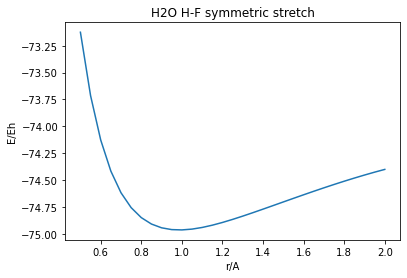

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plot the original surface
plt.plot(rs, list(Es))
plt.title("H2O H-F symmetric stretch")
plt.xlabel("r/A")
plt.ylabel("E/Eh")
plt.show()

We want to describe every bond in the molecule. TO do this we encode the geometry of molecule into a matrix using distance between atoms rij, resultant matrix is coulomb matrix. To differentiate between O-H and H-H we use the atomic charge in the formula Cij = ZiZj/rij for i!=j Cij = 0.5*(Zi)^2.4 for i==j

In [ ]:
#building coulomb matrix
def coulomb(geom,q):
  '''
  Generates the coulomb matrix given geometry and list of atomic charges
  Parameters: 
  geom: list of lists of atomic coordinates [[xi,yi,zi],[xj,yj,zj]...]
  q: list of atomic charges
  '''
  natom = len(q)
  cm = np.zeros((natom,natom))

  for i in range(0,natom):
    for j in range(0,natom):
      if i==j:
        cm[i][j]=q[i]**2.4/2
      else:
        cm[i][j] = q[i]*q[j]/np.linalg.norm(geom[i]-geom[j])

  return cm

#generating coluomb matrix for all geometries and store them in list
couls=[]
for i in range(0,len(geoms)):
  coul=coulomb(geoms[i], qs[i])
  couls.append(coul)


In [ ]:
print(couls[0])

[[73.51669472  8.46683537  8.46683537]
 [ 8.46683537  0.5         0.66926039]
 [ 8.46683537  0.66926039  0.5       ]]


In [ ]:
trainers = [0,7,15,23] # we have 31 geometries so out of those 31, we are selecting 4 geometries here, the 0th, 7th...
X_train=[]
y_train=[]
for t in trainers:
  X_train.append(couls[t].flatten())
  y_train.append(Es[t])

testers=[]
for i in range(0,31):
  testers.append(i)
for t in sorted(trainers, reverse=True):
 del testers[t]

X_test = []
y_test = []
for t in testers:
  X_test.append(couls[t].flatten())
  y_test.append(Es[t])

reg = LinearRegression().fit(X_train, y_train)
y_preds = reg.predict(X_test)


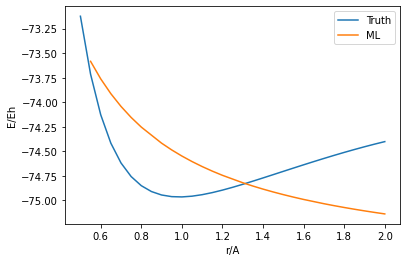

In [ ]:
plt.plot(rs,list(Es),label='Truth')
plt.plot(np.asarray(rs)[testers], y_preds, label='ML')
plt.legend()
plt.xlabel('r/A')
plt.ylabel('E/Eh')
plt.show()

In [ ]:
#kernal ridge regression
krr = KernelRidge(kernel='rbf')
parameters={'alpha': np.logspace(-12,12,num=12),
            'gamma': np.logspace(-12,12,num=12)}
krr_regressor = GridSearchCV(krr, parameters, cv=4, scoring='neg_mean_squared_error')
krr_regressor.fit(X_train, y_train)
y_pred = krr_regressor.predict(X_test)


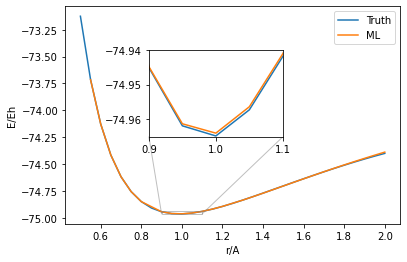

In [ ]:
plt.plot(rs,list(Es),label='Truth')
plt.plot(np.asarray(rs)[testers], y_pred, label='ML')

ax = plt.gca()
axin = ax.inset_axes([0.25,0.4,0.4,0.4])
axin.plot(rs,list(Es))
axin.plot(np.asarray(rs)[testers], y_pred)
axin.set_xlim([0.9,1.1])
axin.set_ylim([-74.965, -74.94])
axin.set_alpha(0)
ax.indicate_inset_zoom(axin,label='_nolegend_')

plt.legend()
plt.xlabel('r/A')
plt.ylabel('E/Eh')
plt.show()


In [ ]:
psi4.set_options({'basis':'sto-3g'})
#initialise geometry list
geoms = []
#charge list
qs = []
#bond length
rs = []

for j in range(0,16):
  rs.append(0.5 + j*0.1)

Es = np.zeros((len(rs),len(rs)))

for i in range(0,len(rs)):
  for j in range(0,len(rs)):
    #generate a water molecule using Z-matrix and set the O-H bond length
    mol = psi4.geometry("""
    O
    H 1 """ + str(rs[i]) + """
    H 1 """ + str(rs[j]) + """ 2 104.5
    symmetry c1
    """)

    #save geometry
    geoms.append(mol.geometry().to_array())
    #save charges for all three atoms
    q = []
    for k in range(mol.natom()):
      q.append(mol.fZ(k))

    qs.append(q)
    #calculate and save energy
    Es[i][j]= psi4.energy('scf')

In [ ]:
print(np.max(Es))
print(np.min(Es))

-73.12426354983927
-74.9647517220917


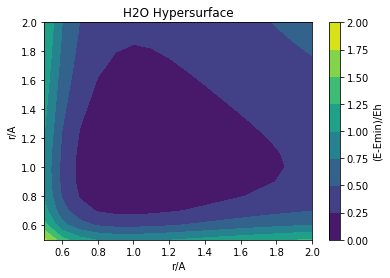

In [ ]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(rs,rs,(Es-np.min(Es)))
cbar = fig.colorbar(cp,label='(E-Emin)/Eh')
ax.set_title('H2O Hypersurface')
ax.set_xlabel('r/A')
ax.set_ylabel('r/A')
plt.show()